# MOVIES RATING PREDICTION APP

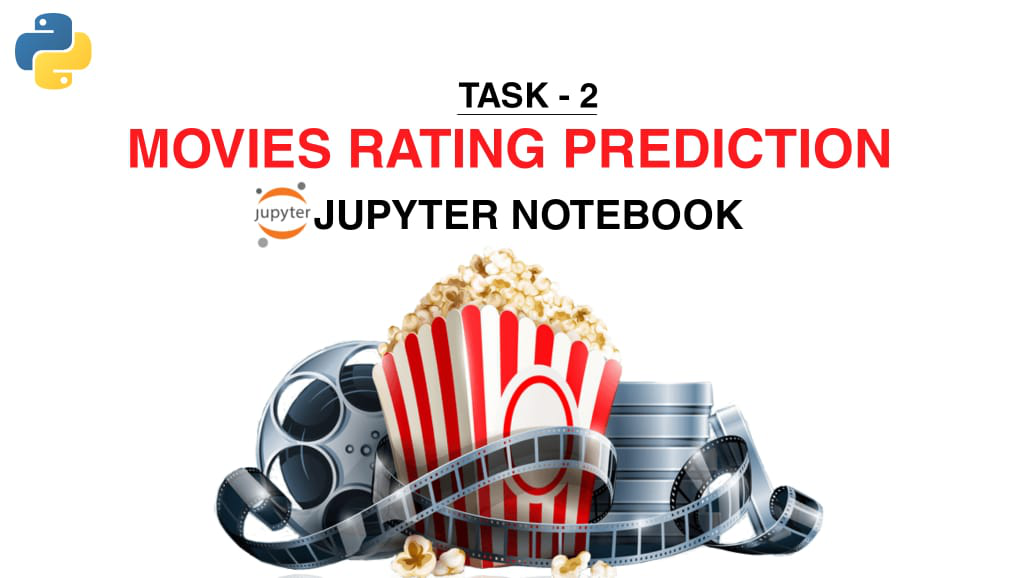

In [2]:
from IPython.display import display
from PIL import Image
image_path = "IMDb rating prediction.jpg"
img = Image.open(image_path)
display(img)

In [3]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, r2_score
import time

In [4]:
def get_movie_input():
    genre = input("Enter Genre: ")
    director = input("Enter Director: ")
    actor1 = input("Enter Actor 1: ")
    actor2 = input("Enter Actor 2: ")
    actor3 = input("Enter Actor 3: ")
    year = float(input("Enter Year: "))
    duration = float(input("Enter Duration (minutes): "))
    votes = float(input("Enter Votes (e.g., 50000): "))
    return pd.DataFrame([[genre, director, actor1, actor2, actor3, \
                          year, duration, votes]],
                         columns=["Genre", "Director", "Actor 1", "Actor 2", "Actor 3", \
                                  "Year", "Duration", "Votes"])


In [5]:
movie_data = pd.read_csv(r"C:\Users\shubh\Downloads\CodSoft Internship\Task - 2\IMDb Movies India.csv", encoding="latin1")
movie_data["Year"] = movie_data["Year"].astype(str).str.extract("(\d{4})")[0].astype(float)
movie_data["Duration"] = movie_data["Duration"].astype(str).str.extract("(\d+)")[0].astype(float)

def clean_votes(vote):
    if isinstance(vote, str):
        vote = vote.replace(",", "").replace("$", "").strip()
        if "M" in vote:
            return float(vote.replace("M", "")) * 1_000_000
        elif "K" in vote:
            return float(vote.replace("K", "")) * 1_000
    try:
        return float(vote)
    except ValueError:
        return np.nan
movie_data["Votes"] = movie_data["Votes"].apply(clean_votes)

In [6]:
movie_data.fillna({
    "Year": movie_data["Year"].median(),
    "Duration": movie_data["Duration"].median(),
    "Rating": movie_data["Rating"].mean(),
    "Votes": movie_data["Votes"].median(),
    "Genre": movie_data["Genre"].mode()[0],
    "Director": movie_data["Director"].mode()[0],
    "Actor 1": movie_data["Actor 1"].mode()[0],
    "Actor 2": movie_data["Actor 2"].mode()[0],
    "Actor 3": movie_data["Actor 3"].mode()[0]
}, inplace=True)

In [7]:
categorical_cols = ["Genre", "Director", "Actor 1", "Actor 2", "Actor 3"]
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    movie_data[col] = le.fit_transform(movie_data[col].astype(str)) 
    label_encoders[col] = le

In [8]:
X = movie_data.drop(columns=["Name", "Rating"])  
y = movie_data["Rating"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train) 
y_pred = rf.predict(X_test)
print(f"Model Performance:\nMAE: {mean_absolute_error(y_test, y_pred):.2f}\nR² Score: {r2_score(y_test, y_pred):.2f}")

Model Performance:
MAE: 0.43
R² Score: 0.32


In [9]:
joblib.dump(rf, "movie_rating_model.pkl")
joblib.dump(label_encoders, "label_encoders.pkl")

model = joblib.load("movie_rating_model.pkl")
label_encoders = joblib.load("label_encoders.pkl")

In [10]:
def encode_input_value(encoder, value):
    """Encodes a categorical value using the given LabelEncoder.
       If the value is not in the encoder classes, assigns the most frequent encoded value.
    """
    if value in encoder.classes_:
        return encoder.transform([value])[0]
    else:
        return encoder.transform([encoder.classes_[0]])[0]

In [ ]:
def predict_rating_for_movies():
    while True:
        user_data = get_movie_input()

        for col in ["Genre", "Director", "Actor 1", "Actor 2", "Actor 3"]:
            if col in label_encoders:
                user_data[col] = user_data[col].apply(lambda x: encode_input_value(label_encoders[col], x))
            else:
                user_data[col] = -1  

        user_data = user_data.reindex(columns=X.columns)
        user_data = user_data.astype(float)
        predicted_rating = model.predict(user_data)
        print("\nPredicted IMDb Rating:", round(predicted_rating[0], 2))
        time.sleep(2)
        
        another_movie = input("\nDo you want to predict the rating for another movie? (y/n): ")
        if another_movie.lower() != 'y':
            break

predict_rating_for_movies()

Enter Genre:  Action
Enter Director:  xyz
Enter Actor 1:  abc
Enter Actor 2:  mbd
Enter Actor 3:  mdbd
Enter Year:  2025
